In [1]:
import io
import os
import re
import shutil
import string
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, TextVectorization, Embedding
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.utils import plot_model

In [2]:
DATASET = "imdb_reviews" # datasets: "imdb_reviews", "yelp_polarity_reviews"

DROPOUT_RATE = 0.5
DENSE_HIDDEN_UNITS = 200
BATCH_SIZE = 64
NB_CLASSES = 2
BUFFER_SIZE = 10000

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSINXYK/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSINXYK/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSINXYK/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(5):
  print('text: ', example.numpy())
  print('type data: ', type(example))
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
type data:  <class 'tensorflow.python.framework.ops.EagerTensor'>
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. How

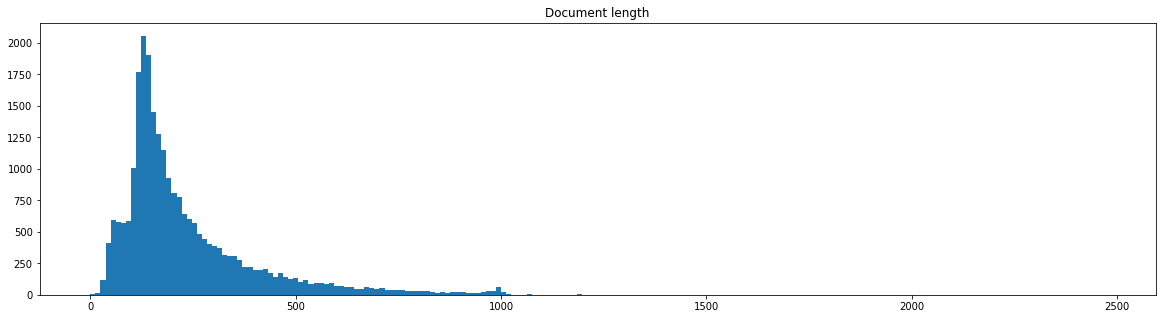

Text informations:
 - number of seq:  25000
 - max length:     2470
 - min length:     10
 - mean length:    233.77672


In [5]:
num_token = [len(str(text.numpy()).split()) for text, label in train_dataset.take(count=-1)]

# Plot histogram
plt.figure(figsize=(20,5))
plt.title("Document length")
plt.hist(num_token, 200, density=False, range=(0,np.max(num_token)))
plt.show()

print("Text informations:")
print(f" - number of seq:  {len(num_token)}")
print(f" - max length:     {np.max(num_token)}")
print(f" - min length:     {np.min(num_token)}")
print(f" - mean length:    {np.mean(num_token)}")

In [6]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQ_LENGTH = 400

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Who actually created this piece of crap this is the worst movie i have ever seen in my life it is such a waste of time and money. I hate it how they create low budget sequels featuring D-Lister actors and a storyline so similar to the 1st one.<br /><br />I found this movie in the bargain bin sitting right next to Wild Things 2 and Death To The Supermodels for $2.99 what a fool i was to actually think that this could be good instead i watched in disgust as poor acting stereotypes ripped of the storyline and script from the 1st one.<br /><br />Whoever thought that this straight-to-video production was actually even a half decent film you must be on crackd or something because I think what pretty much most of the people who've seen this film thinks WHAT A LOAD OF CRAP!!!!"
 b'This movie is absolutely pointless, one of the good esamples how Malcom McDowall never got one decent role after Clockwork Orange. This one may be one of the worst though. No story, crappy special effects,

In [9]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), 
                                  '')

encoder = TextVectorization(
    standardize = custom_standardization,
    max_tokens =  VOCAB_SIZE,
    output_mode = 'int',
    output_sequence_length = MAX_SEQ_LENGTH)

encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film'],
      dtype='<U17')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  36,  157, 1064, ...,    0,    0,    0],
       [  11,   17,    7, ...,    0,    0,    0],
       [   9,    7,  855, ...,    0,    0,    0]])

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Who actually created this piece of crap this is the worst movie i have ever seen in my life it is such a waste of time and money. I hate it how they create low budget sequels featuring D-Lister actors and a storyline so similar to the 1st one.<br /><br />I found this movie in the bargain bin sitting right next to Wild Things 2 and Death To The Supermodels for $2.99 what a fool i was to actually think that this could be good instead i watched in disgust as poor acting stereotypes ripped of the storyline and script from the 1st one.<br /><br />Whoever thought that this straight-to-video production was actually even a half decent film you must be on crackd or something because I think what pretty much most of the people who've seen this film thinks WHAT A LOAD OF CRAP!!!!"
Round-trip:  who actually created this piece of crap this is the worst movie i have ever seen in my life it is such a waste of time and money i hate it how they create low budget sequels featuring [UNK] act

In [13]:
model = Sequential([
                    encoder,
                    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM,
                              mask_zero=True),
                    Bidirectional(LSTM(64,
                                       dropout=DROPOUT_RATE)),
                    Dense(64, activation='relu', kernel_regularizer='l2'),
                    Dropout(DROPOUT_RATE),
                    Dense(1, activation='sigmoid')
])

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 400)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 400, 100)          1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

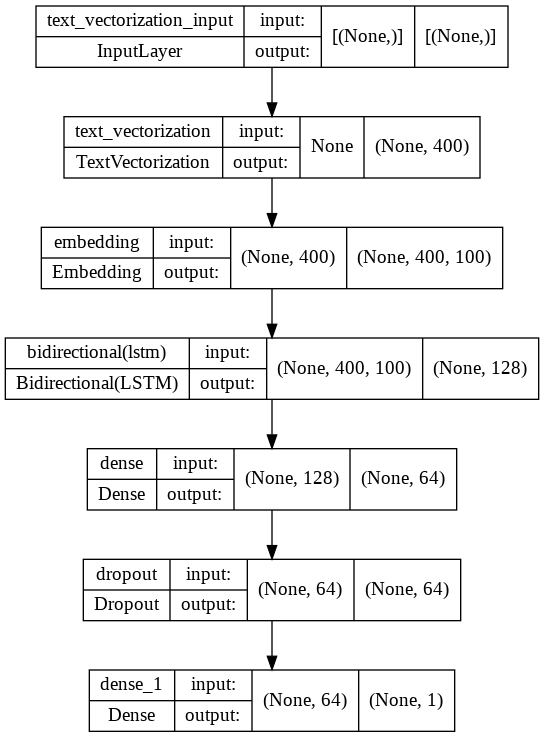

In [16]:
plot_model(model, show_shapes=True)

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 34s 53ms/step - loss: 1.3094 - accuracy: 0.5522 - val_loss: 1.0409 - val_accuracy: 0.6875
Epoch 2/10
391/391 [==============================] - 18s 45ms/step - loss: 0.8393 - accuracy: 0.7676 - val_loss: 0.7415 - val_accuracy: 0.7859
Epoch 3/10
391/391 [==============================] - 18s 45ms/step - loss: 0.5827 - accuracy: 0.8397 - val_loss: 0.5362 - val_accuracy: 0.8422
Epoch 4/10
391/391 [==============================] - 19s 46ms/step - loss: 0.4660 - accuracy: 0.8564 - val_loss: 0.4567 - val_accuracy: 0.8500
Epoch 5/10
391/391 [==============================] - 18s 45ms/step - loss: 0.3860 - accuracy: 0.8710 - val_loss: 0.4151 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 18s 45ms/step - loss: 0.3488 - accuracy: 0.8877 - val_loss: 0.3960 - val_accuracy: 0.8625
Epoch 7/10
391/391 [==============================] - 18s 45ms/step - loss: 0.3137 - accuracy: 0.8932 - val_loss: 0.3736 - val_accuracy:

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 10s 25ms/step - loss: 0.3619 - accuracy: 0.8654
Test Loss: 0.36193808913230896
Test Accuracy: 0.8654000163078308


In [19]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

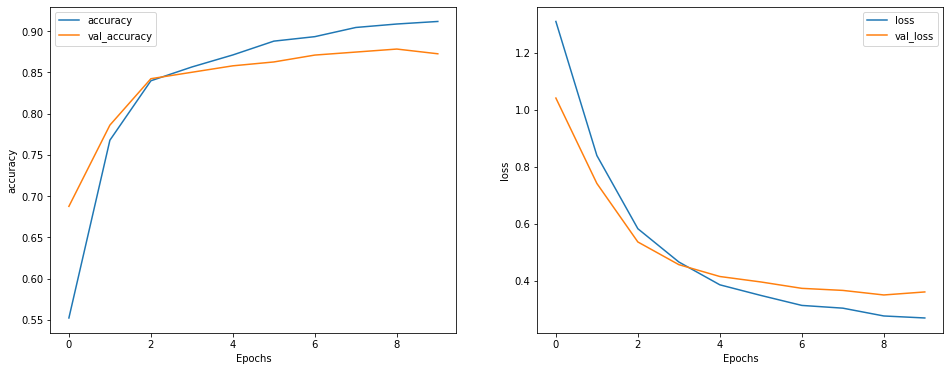

In [20]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [22]:
model1 = tf.keras.Sequential([
    encoder,
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM,
                              mask_zero=True),
    Bidirectional(tf.keras.layers.LSTM(128,
                                       dropout=DROPOUT_RATE,
                                       return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64,
                                       dropout=DROPOUT_RATE,
                                       return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(32,
                                       dropout=DROPOUT_RATE)),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
])

In [23]:
model1.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 400)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 400, 100)          1000000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 400, 256)         234496    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 400, 128)         164352    
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               41216     
 nal)                                                 

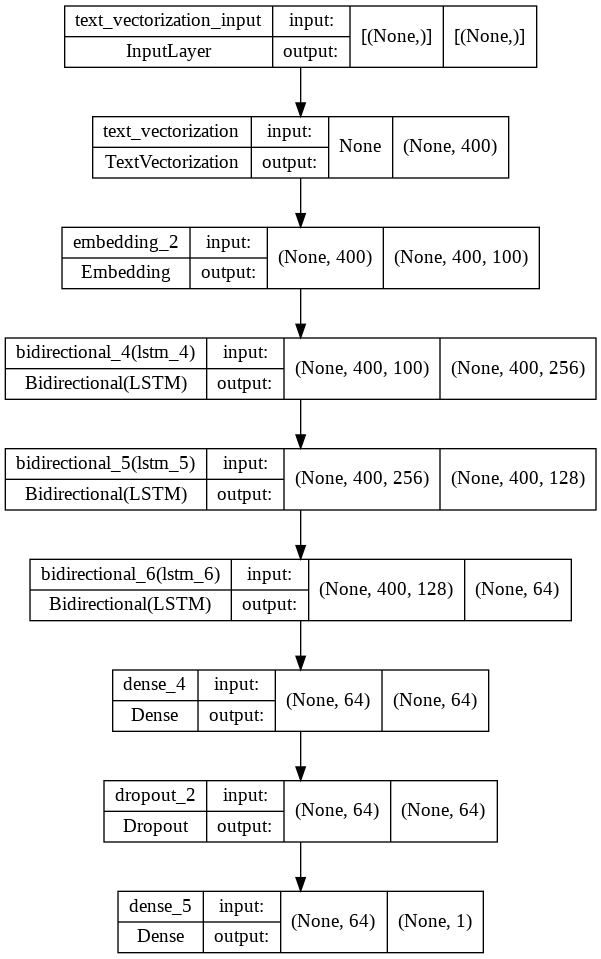

In [25]:
plot_model(model1, show_shapes=True)

In [26]:
history1 = model1.fit(train_dataset, epochs=10,
                      validation_data=test_dataset,
                      validation_steps=30)

Epoch 1/10
391/391 [==============================] - 75s 141ms/step - loss: 1.1536 - accuracy: 0.5755 - val_loss: 0.8751 - val_accuracy: 0.7958
Epoch 2/10
391/391 [==============================] - 50s 126ms/step - loss: 0.6727 - accuracy: 0.8485 - val_loss: 0.5540 - val_accuracy: 0.8760
Epoch 3/10
391/391 [==============================] - 49s 125ms/step - loss: 0.4604 - accuracy: 0.8966 - val_loss: 0.4436 - val_accuracy: 0.8854
Epoch 4/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3492 - accuracy: 0.9158 - val_loss: 0.3867 - val_accuracy: 0.8854
Epoch 5/10
391/391 [==============================] - 49s 124ms/step - loss: 0.2770 - accuracy: 0.9267 - val_loss: 0.3580 - val_accuracy: 0.8797
Epoch 6/10
391/391 [==============================] - 49s 124ms/step - loss: 0.2289 - accuracy: 0.9366 - val_loss: 0.3487 - val_accuracy: 0.8792
Epoch 7/10
391/391 [==============================] - 49s 125ms/step - loss: 0.2001 - accuracy: 0.9407 - val_loss: 0.3411 - val_ac

In [27]:
test_loss, test_acc = model1.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 22s 56ms/step - loss: 0.4134 - accuracy: 0.8618
Test Loss: 0.41336292028427124
Test Accuracy: 0.8618000149726868


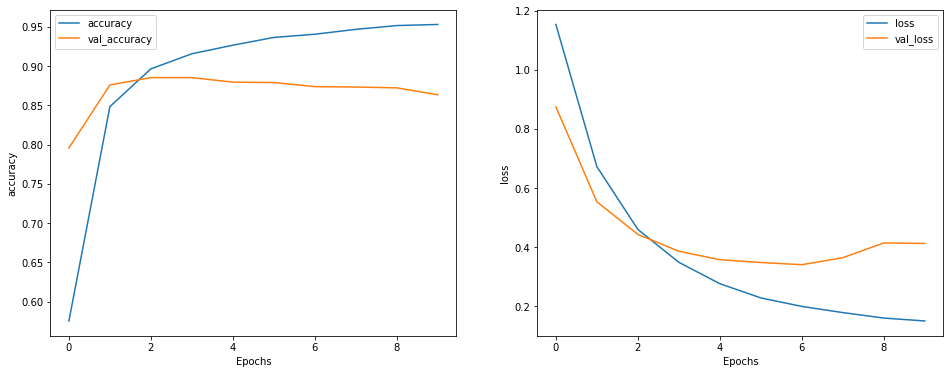

In [28]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history1, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history1, 'loss')